<a href="https://colab.research.google.com/github/Shubham-M-Rathod/Digital-Gym-Trainer/blob/main/Digital_Gym_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

In [ ]:
############## Initialization ###########

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

In [ ]:
import mediapipe as mp
import matplotlib.pyplot as plt

In [ ]:
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images - independently for the images standalone processing.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Initialize mediapipe drawing class - to draw the landmarks points.
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def detectPose(image_pose, pose):
    if image_pose is None:
      return None, None
    final_image = image_pose.copy()
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    resultant = pose.process(image_in_RGB)
    if resultant.pose_landmarks:
        mp_drawing.draw_landmarks(image=final_image, landmark_list=resultant.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=3, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                       thickness=2, circle_radius=2))
    return resultant.pose_landmarks, final_image

In [ ]:
def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    return angle

In [ ]:
def generate_video(images):
    if images is None or images[0] is None:
      return []
    height, width, layers = images[0].shape
    data = []
    for image in images:
        landmarks, res_image = detectPose(image, pose_image)
        if landmarks:
          data.append(landmarks.landmark)
    return data

In [ ]:
def FrameCapture(path):
    vidObj = cv2.VideoCapture(path)
    count = 0
    success = 1
    images=[]
    while success:
      success, image = vidObj.read()
      images.append(image)
    vidObj.release()
    return images

In [ ]:
############ Plank ########################

In [ ]:
video_frames = FrameCapture('/content/plank_3.mp4')
video_data = generate_video(video_frames)
def correction(video_data):
  final_video=[]
  flag_r=0
  if video_data[0][mp_pose.PoseLandmark.RIGHT_ANKLE].z<=video_data[0][mp_pose.PoseLandmark.LEFT_ANKLE].z:
    flag_r=1
  for i in range(len(video_frames)-1):
    # print(i)
    if video_frames[i].any()==None:
      continue
    if flag_r==1:
      a = video_data[i][mp_pose.PoseLandmark.RIGHT_ANKLE]
      s = video_data[i][mp_pose.PoseLandmark.RIGHT_SHOULDER]
      w = video_data[i][mp_pose.PoseLandmark.RIGHT_WRIST]
      h = video_data[i][mp_pose.PoseLandmark.RIGHT_HIP]
      k = video_data[i][mp_pose.PoseLandmark.RIGHT_KNEE]
    else:
      a = video_data[i][mp_pose.PoseLandmark.LEFT_ANKLE]
      s = video_data[i][mp_pose.PoseLandmark.LEFT_SHOULDER]
      w = video_data[i][mp_pose.PoseLandmark.LEFT_WRIST]
      h = video_data[i][mp_pose.PoseLandmark.LEFT_HIP]
      k = video_data[i][mp_pose.PoseLandmark.LEFT_KNEE]
    a_x=int(a.x*video_frames[i].shape[1])
    a_y=int(a.y*video_frames[i].shape[0])
    s_x=int(s.x*video_frames[i].shape[1])
    s_y=int(s.y*video_frames[i].shape[0])
    w_x=int(w.x*video_frames[i].shape[1])
    w_y=int(w.y*video_frames[i].shape[0])
    final_frame = video_frames[i].copy()
    cv2.line(final_frame, (s_x, s_y), (a_x,a_y), (0, 0, 255), 2)
    cv2.line(final_frame, (s_x, s_y), (s_x,w_y), (0, 0, 255), 2)
    # print(calculate_angle([h.x,h.y,h.z],[k.x,k.y,k.z],[a.x,a.y,a.z]))
    # print(calculate_angle([k.x,k.y,k.z],[h.x,h.y,h.z],[s.x,s.y,s.z]))
    if not(165<=calculate_angle([h.x,h.y,h.z],[k.x,k.y,k.z],[a.x,a.y,a.z])<=195):
      # print('Incorrect At Knee')
      final_frame = cv2.putText(final_frame, 'Incorrect At Knee', (100,50), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, 2)
    if not(165<=calculate_angle([k.x,k.y,k.z],[h.x,h.y,h.z],[s.x,s.y,s.z])<=195):
      # print('Incorrect At Hip')
      final_frame = cv2.putText(final_frame, 'Incorrect At Back', (100,100), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, 2)
    # final_video.append(final_frame)
    final_video.append(detectPose(final_frame, pose_image)[1])
  return final_video

In [ ]:
final_video = correction(video_data)
# print(len(video_frames))
height, width, layers = final_video[0].shape
video = cv2.VideoWriter('video.avi',
                        cv2.VideoWriter_fourcc(*'MP4V'), 24,(width, height))
for image in final_video:
      video.write(image)

In [ ]:
########### Pushups ###################

In [ ]:
import joblib
autoencoder = joblib.load('autoencoder.joblib')
encoder = joblib.load('encoder.joblib')
decoder = joblib.load('decoder.joblib')

In [ ]:
encoder.save('encoder.h5')
decoder.save('decoder.h5')

In [ ]:
input_frames = FrameCapture('/content/Copy of push up 175.mp4')
height, width, layers = input_frames[0].shape
video = cv2.VideoWriter('video.avi',
                        cv2.VideoWriter_fourcc(*'MP4V'), 40,(width, height))
for z in input_frames:
  input_data_landmarks, _ = detectPose(z, pose_image)
  if input_data_landmarks is None: continue
  input_data = []
  for j in input_data_landmarks.landmark:
    input_data.append([j.x,j.y,j.z])
  encoded_imgs = encoder.predict(np.array(input_data).reshape(1,99))
  decoded_imgs = decoder.predict(encoded_imgs)
  ans_ = decoded_imgs[0].reshape(33,3)
  # for center in ans_:
  #   cx,cy=center[0]*z.shape[1],center[1]*z.shape[0]
  #   cv2.circle(z, (int(cx), int(cy)), 2, (0,0,255), 2)
  #   video.write(z)
  cv2.line(z, (int(ans_[11][0]*z.shape[1]),int(ans_[11][1]*z.shape[0])),(int(ans_[13][0]*z.shape[1]),int(ans_[13][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[13][0]*z.shape[1]),int(ans_[13][1]*z.shape[0])),(int(ans_[15][0]*z.shape[1]),int(ans_[15][1]*z.shape[0])),(0,0,255), 2)

  cv2.line(z, (int(ans_[12][0]*z.shape[1]),int(ans_[12][1]*z.shape[0])),(int(ans_[14][0]*z.shape[1]),int(ans_[14][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[14][0]*z.shape[1]),int(ans_[14][1]*z.shape[0])),(int(ans_[16][0]*z.shape[1]),int(ans_[16][1]*z.shape[0])),(0,0,255), 2)

  cv2.line(z, (int(ans_[12][0]*z.shape[1]),int(ans_[12][1]*z.shape[0])),(int(ans_[24][0]*z.shape[1]),int(ans_[24][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[11][0]*z.shape[1]),int(ans_[11][1]*z.shape[0])),(int(ans_[23][0]*z.shape[1]),int(ans_[23][1]*z.shape[0])),(0,0,255), 2)

  cv2.line(z, (int(ans_[24][0]*z.shape[1]),int(ans_[24][1]*z.shape[0])),(int(ans_[26][0]*z.shape[1]),int(ans_[26][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[26][0]*z.shape[1]),int(ans_[26][1]*z.shape[0])),(int(ans_[28][0]*z.shape[1]),int(ans_[28][1]*z.shape[0])),(0,0,255), 2)

  cv2.line(z, (int(ans_[23][0]*z.shape[1]),int(ans_[23][1]*z.shape[0])),(int(ans_[25][0]*z.shape[1]),int(ans_[25][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[25][0]*z.shape[1]),int(ans_[25][1]*z.shape[0])),(int(ans_[27][0]*z.shape[1]),int(ans_[27][1]*z.shape[0])),(0,0,255), 2)

  cv2.line(z, (int(ans_[11][0]*z.shape[1]),int(ans_[11][1]*z.shape[0])),(int(ans_[12][0]*z.shape[1]),int(ans_[12][1]*z.shape[0])),(0,0,255), 2)
  cv2.line(z, (int(ans_[23][0]*z.shape[1]),int(ans_[23][1]*z.shape[0])),(int(ans_[24][0]*z.shape[1]),int(ans_[24][1]*z.shape[0])),(0,0,255), 2)

  err = np.mean(((np.array(input_data)-np.array(ans_))*100)**2)
  if err>=10:
    z=cv2.putText(z, 'Incorrect', (100,50), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, 2)
  else:
    z=cv2.putText(z, 'Correct', (100,50), cv2.FONT_HERSHEY_SIMPLEX,
                   1, (0, 0, 255), 2, 2)
  video.write(detectPose(z, pose_image)[1])
  # video.write(z)

1/1 [==============================] - 0s 16ms/step


In [ ]:
################# END #################
######## Aage ka kaam ka nahi ##############

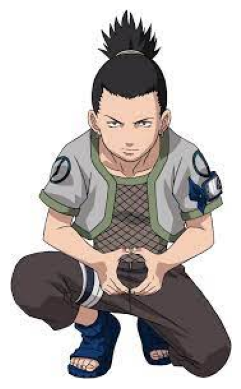

In [ ]:
# img = cv2.imread('character.jpg')
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
# plt.axis('off');

In [ ]:
# landmarks, res_img = detectPose(img, pose_image)

(-0.5, 173.5, 289.5, -0.5)

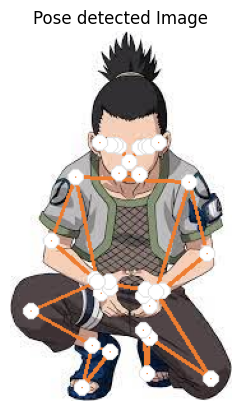

In [ ]:
# plt.imshow(cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))
# plt.title("Pose detected Image")
# plt.axis('off')

In [ ]:
# rs = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
# re = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
# rw = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
# calculate_angle([rs.x,rs.y,rs.z],[re.x,re.y,re.z],[rw.x,rw.y,rw.z])

86.02738359490434

In [ ]:
#####################   Autoencoder Data Preparation     ################

In [ ]:
x_train = []
from tqdm import tqdm
for i in tqdm(range(1,200)):
  x_frames = FrameCapture('/content/Copy of push up %d.mp4'%i)
  x_data = generate_video(x_frames)
  for j in x_data:
    x_row = []
    for k in j:
      x_row.append([k.x,k.y,k.z])
    x_train.append(x_row)

100%|██████████| 199/199 [03:51<00:00,  1.16s/it]


In [ ]:
import joblib
# joblib.dump(x_train, 'datas.joblib')
# x_train = joblib.load('datas.joblib')

In [ ]:
x_train[0]

[[0.7377414703369141, 0.6113031506538391, 0.014358839020133018],
 [0.7513325214385986, 0.5946463942527771, 0.02081548608839512],
 [0.7512305974960327, 0.5908474326133728, 0.020695116370916367],
 [0.7513718008995056, 0.5860805511474609, 0.020553234964609146],
 [0.7513898611068726, 0.5924680233001709, -0.02054126001894474],
 [0.7512394785881042, 0.5874399542808533, -0.020617054775357246],
 [0.7512713074684143, 0.5815743207931519, -0.02067508175969124],
 [0.7410324811935425, 0.5387846231460571, 0.08413755893707275],
 [0.7412424683570862, 0.5416519045829773, -0.10250069946050644],
 [0.7188307046890259, 0.594871461391449, 0.047597333788871765],
 [0.7178928256034851, 0.5925030708312988, -0.007626473903656006],
 [0.6356715559959412, 0.4913315773010254, 0.20926780998706818],
 [0.6605976819992065, 0.5591834783554077, -0.18139083683490753],
 [0.62108314037323, 0.6734548807144165, 0.2795226275920868],
 [0.6559840440750122, 0.8363907933235168, -0.22992463409900665],
 [0.6442257761955261, 0.7968212

In [ ]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

# Prepare your train data (X_train) and input data (input_data)
# Assuming x_train is a list of 2D arrays of shape (3, 33)

# Flatten the 2D arrays into 1D arrays
x_train_flattened = np.array([arr.flatten() for arr in np.array(x_train)])

# Define the dimensions of your input data
input_dim = 99

# Define the dimensions of the latent space
latent_dim = 8

# Define the autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(latent_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

# Create the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using your train data
autoencoder.fit(x_train_flattened, x_train_flattened, epochs=100, batch_size=32)


In [ ]:
# import keras
# from keras import layers

# input_img = keras.Input(shape=(33, 3, 1))

# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (5, 1, 8) i.e. 40-dimensional

# x = layers.UpSampling2D((2, 2))(encoded)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.fit(x_train, x_train, epochs=100, batch_size=32)

In [ ]:
autoencoder.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 99)]              0         
                                                                 
 dense_60 (Dense)            (None, 128)               12800     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_64 (Dense)            (None, 128)               4224      
                                                                 
 dense_65 (Dense)            (None, 99)                12771     
                                                                 
Total params: 40,131
Trainable params: 40,131
Non-trainabl

In [ ]:
# ############################### Deeper Model ##############################
# import keras
# from keras import layers

# input_layer = Input(shape=(input_dim,))
# encoded = layers.Dense(128, activation='relu')(input_layer)
# encoded = layers.Dense(64, activation='relu')(encoded)
# encoded = layers.Dense(32, activation='relu')(encoded)

# decoded = layers.Dense(64, activation='relu')(encoded)
# decoded = layers.Dense(128, activation='relu')(encoded)
# decoded = layers.Dense(input_dim, activation='tanh')(decoded)

# autoencoder = keras.Model(input_layer, decoded)
# autoencoder.compile(optimizer='adam', loss='mae')

from keras.layers import Input, Dense
from keras.models import Model

x_train_flattened = np.array([arr.flatten() for arr in np.array(x_train)])

# Define the dimensions of your input data
input_dim = 99

# Define the dimensions of the latent space
latent_dim = 8

# Define the autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)
# Create the encoder model
encoder = Model(inputs=input_layer, outputs=encoded)

# Define the decoder architecture
encoded_input = Input(shape=(latent_dim,))
decoded = Dense(32, activation='relu')(encoded_input)
decoded = Dense(64, activation='relu')(encoded_input)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='tanh')(decoded)

# Create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoded)

# Create the full autoencoder model by chaining the encoder and decoder
autoencoder = Model(inputs=input_layer, outputs=decoder(encoder(input_layer)))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(x_train_flattened, x_train_flattened, epochs=100, batch_size=32, shuffle=True)


Epoch 1/100
141/141 [==============================] - 3s 4ms/step - loss: 0.1191
Epoch 2/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0392
Epoch 3/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0295
Epoch 4/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0256
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0237
Epoch 6/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0227
Epoch 7/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0214
Epoch 8/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0205
Epoch 9/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0199
Epoch 10/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0191
Epoch 11/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0185
Epoch 12/100
141/141 [==============================] - 1s 4ms/step - loss: 0.0183
Epoch 13/100
